In [1]:
import spacy
import en_core_web_sm 
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.cluster import KMeans , DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import hdbscan
from sklearn.neighbors import NearestNeighbors

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
from wordcloud import WordCloud, get_single_color_func

In [2]:
# Load the English language model from spacy
nlp = en_core_web_sm.load()

# Compile a regular expression pattern for removing punctuation and special characters from text
pattern = re.compile(r"[!\'#$%&()*+,-./:;<=>?@[\\\]^_`{|}~]+")

# Define a list of custom stop words that are not typically useful for text analysis
custom_stop_words = ['br', 'b', 'li', 'ul', 've', 'll', 's']

## 1 - Downlaod and cleaning

In [3]:
# Load and display the dataset from a CSV file into a pandas DataFrame
NF_corpus = pd.read_csv('sample-data.csv')
NF_corpus.head()

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

In [4]:
# Create 2 new columns from 'description' column
NF_corpus[['article', 'article_description']] = NF_corpus['description'].str.split("-", n=1, expand=True)
NF_corpus.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      article  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                 article_description  
0   There's a reason why our boxers are a cult fa...  
1   Skinning up Glory requires enough movement wi...  
2   These superbreathable no-fly briefs are the m...  
3   Skin in, climb ice, switch to rock, traverse ...  
4   On high ridges, steep ice and anything alpine...

In [5]:
# Create a new column with simple name of article
def replace_simple_article (dataframe, column_name, article_name, article_replacement):
    # Ensure the lists of original names and their replacements have the same length
    if len(article_name) != len(article_replacement):
        raise ValueError('The lenght of article_name and article_replacement should be the same')
        
    # Create a dictionnary
    replacement_dict = dict(zip(article_name, article_replacement))

    # Function to replace each name in the column with its simplified form or label it as 'others'
    def replace_word(text):
        for original, replacement in replacement_dict.items():
            if original in text:
                return replacement
        return 'Others'
    
    #Apply the replacement function
    return dataframe[column_name].apply(replace_word)

In [6]:
# Define the original names or keywords of articles and their corresponding simplified names or categories
article_name = ['boxers', 'briefs', 'pants', 'jkt', 'hat', 'Cap', 'vest', 'shorts', 'socks', 'shirt', 'duffel', 'dress', 'belt', 'jeans', 'hoody', 'btm', 't', 'rashguard', 'Baby', 'capris']
article_replacement = ['Boxer', 'Brief', 'Pants', 'Jacket', 'Hat', 'Cap', 'Vest', 'Shorts', 'Socks', 'Shirt', 'Duffel', 'Dress', 'Belt', 'Jeans', 'Hoody', 'Bomber', 'T-shirt', 'Rashguard', 'Baby_clothes', 'Capris']

# Apply the replacement function to the 'article' column of NF_corpus DataFrame
NF_corpus['simple_article'] = replace_simple_article(NF_corpus, 'article', article_name, article_replacement)

In [7]:
# Display NF_corpus
NF_corpus.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      article  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                 article_description simple_article  
0   There's a reason why our boxers are a cult fa...          Boxer  
1   Skinning up Glory requires enough movement wi...          Brief  
2   These superbreathable no-fly briefs are the m...          Brief  
3   Skin in, climb ice, switch to rock, traverse ...          Pants  
4   On high ridges, steep ice and anything alpine...         Jacket

In [8]:
# Function to preprocess text data within a given DataFrame column
def preprocess_text(text):
    # Remove punctuation and special characters, then convert text to lowercase
    text_clean = pattern.sub(" ", text).lower().strip()

    # Process text through spaCy NLP pipeline to obtain a doc object
    doc = nlp(text_clean)

    # Perform lemmatization, excluding custom and default stop words
    lemma = ' '.join([token.lemma_ for token in doc if token.text not in custom_stop_words and not token.is_stop])

    return lemma

# Apply the preprocessing function to the 'article_description' column
NF_corpus['description_lemmatized'] = NF_corpus['article_description'].apply(preprocess_text)

In [9]:
# Calculate the length for each lemmatized description and store it in a new column
NF_corpus['len_description'] = NF_corpus['description_lemmatized'].apply(lambda x: len(x))

In [10]:
# Word count in description lemmatized
NF_corpus['word_count'] = NF_corpus['description_lemmatized'].apply(lambda x: len(x.split()))

In [11]:
# Display NF_corpus
NF_corpus.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      article  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                 article_description simple_article  \
0   There's a reason why our boxers are a cult fa...          Boxer   
1   Skinning up Glory requires enough movement wi...          Brief   
2   These superbreathable no-fly briefs are the m...          Brief   
3   Skin in, climb ice, switch to rock, traverse ...          Pants   
4   On high ridges, steep ice and anything alpine...         Jacket   

                              description_lemmatized  len_description  \
0  reason boxer cult favorite    cool   especiall...              728   
1  skin glory require movement boxer decide poach...              792   
2  superbreathable fly brief minimalist choice hi...              682   
3  skin   climb ice   switch rock   traverse knif...              989   
4  high ridge   steep ice alpine   jacket serve t...             1469   

   word_count  
0         109  
1         125  
2         100  
3         143  
4         209

In [12]:
# Class for matching color between WordCloud and TruncatedVSD plot 
class SimpleGroupedColorFunc(object):
    """Simple colour function to assign the same colour to all words."""
    def __init__(self, color):
        self.color = color
    
    def __call__(self, word, **kwargs):
        return self.color

In [13]:
# Defining a color palette as a dictionary where cluster indices map to specific color codes
color_map = {0: '#58001b', 1: '#2b0342', 2: '#285800', 3: '#626200', 4: '#983351', 5: '#582a72', 6: '#609732', 7: '#aaaa39', 8: '#d89bad', 9: '#9276a1', 10: '#73e7e7',
              11: '#134c13', 12: '#f5a665', 13: '#f56565', 14: '#5f1818', 15: '#0e3939', 16: '#aa3939', 17: '#226666', 18: '#aa6c39', 19: '#f88300'}

## 2 - EDA

In [14]:
# Creating a histogram to review the distribution of simplified article names in the NF_corpus DataFrame.
fig = px.histogram(NF_corpus, x='simple_article',
                   color_discrete_sequence=['#58001b'])
fig.update_layout(title_text='Review Article in NF_corpus', xaxis_title_text='Article', yaxis_title_text='Count', bargap=0.1)
fig.show()

</u><ins><center> <font color="#ffe800"><ins>Observations</font> </center>
</br>
The "Review Article in NF_corpus" histogram provides a clear visualization of the distribution of various types of articles listed on the North Face website. The dataset reveals a wide range of product types, with notable differences in their frequencies.

The most common product type by a significant margin is T-shirts, totaling 175 entries, suggesting a strong emphasis on this category in the North Face's product lineup. Following T-shirts, Pants and Shorts each have a substantial presence with 41 and 40 entries respectively, highlighting the brand's focus on offering a variety of options in these categories for outdoor and athletic activities.

On the other end of the spectrum, categories like Boxers, Baby-clothes, Duffel, and Jeans are among the least represented with only 2 to 6 entries each. This indicates these product types might be more specialized or niche offerings compared to the core product lines.

The "Others" category, with 58 entries, suggests there is a considerable number of products that do not fit neatly into the predefined categories, pointing towards the diversity in the North Face's product range.

</u><ins><center> <font color="ffe800"><ins>Conclusion</font> </center>
</br>
the histogram underscores the North Face's emphasis on T-shirts, Pants, and Shorts, indicating these are likely key areas of interest for their target market. The presence of a wide range of product types, including specialized categories and a significant "Others" group, highlights the brand's broad appeal and its commitment to catering to a diverse set of customer needs and outdoor activities.

In [15]:
# Generating a histogram to analyze the distribution of the lengths of lemmatized article descriptions in NF_corpus.
fig = px.box(NF_corpus, y='len_description',
                    color_discrete_sequence=['#2b0342'])
fig.update_layout(title_text='Review description lenght distribution', xaxis_title_text='Length', yaxis_title_text='Count', bargap=0.1)
fig.show()

</u><ins><center> <font color="#ffe800"><ins>Observations</font> </center>
</br>
The boxplot of the length of descriptions shows a median of 742.5 characters, indicating that half of the product descriptions have less than 742.5 characters while the other half has more. This mid-point provides an overview of the "standard" length of descriptions in the corpus.

The first quartile (Q1) is 556.5 characters and the third quartile (Q3) is 1021 characters, meaning that 25% of descriptions are shorter than 556.5 characters and 25% are longer than 1021 characters. The interquartile interval (Q3 - Q1), which is 464.5 characters, reflects the variability in length of descriptions around the median. A relatively broad IQR suggests some diversity in how products are described.

The "lower fence" (lower limit) at 238 characters and the "upper fence" (upper limit) at 1691 characters delimit the range of lengths considered typical for the descriptions, with values outside this range potentially considered as outliers.

Descriptions longer than 1691 characters, including 1769, 1944, 2146, 2850 characters, are classified as outliers. These extremely long descriptions are out of the ordinary and may require special attention to determine if their length is justified by the complexity of the product or if they could be condensed to improve readability.

</u><ins><center> <font color="#ffe800"><ins>Conclusion</font> </center>
</br>
This boxplot reveals a trend towards moderately long product descriptions at North Face, with significant variability. Although most descriptions are concise and informative, a minority of them are extremely long, perhaps highlighting instances where additional information is provided for complex or high-end products. Identified outliers indicate optimization opportunities by assessing the need for such lengths to improve clarity and efficiency of communication with customers.

In [16]:
# Creating a histogram to explore the distribution of word counts in the lemmatized descriptions of the NF_corpus DataFrame.
fig = px.box(NF_corpus, y='word_count',
                   color_discrete_sequence=['#285800'])
fig.update_layout(title_text='Review description word count distribution', xaxis_title_text='Word_count', yaxis_title_text='Count', bargap =0.1)
fig.show()

</u><ins><center> <font color="#ffe800"><ins>Observations</font> </center>
</br>

**Central Trends and Dispersion**: The median is 110.5 words, indicating that half of the descriptions contain less than 110.5 words, while the other half contains more. This gives an idea of the "typical" length of descriptions in your corpus. The quartiles (Q1 to 85.5 and Q3 to 146.5) show that 50% of the descriptions have between 85.5 and 146.5 words. The interquartile difference (IQR = Q3 - Q1) provides a measure of the dispersion of the data around the median, which here is 61 words.

**Outliers**: The presence of outliers (248, 270, 309, 393) beyond the "upper fence" (233 words) indicates descriptions significantly longer than the majority. These extreme values suggest that some products have very detailed descriptions.

**Variability of Descriptions**: The "min" (38 words) and the "max" (400 words) show the full range of lengths of descriptions, revealing great variability in the amount of information provided through product descriptions.

</u><ins><center> <font color="#ffe800"><ins>Conclusions</font> </center>
</br>
The boxplot reveals a general trend towards moderate length product descriptions on the North Face site, with a significant variety in terms of detail provided. The majority of descriptions seem to be designed to be informative while remaining concise, probably to facilitate quick reading by consumers. However, the outliers report that for some products, North Face chooses to offer much more complete information, possibly for complex items requiring additional explanation or to highlight unique features and significant benefits.

This analysis suggests a balanced content strategy that aims to cover both the needs of consumers who prefer succinct information and those who want in-depth product details. The identification of outliers can also offer avenues to optimize the content strategy by re-evaluating the need for extremely long descriptions for certain products, and ensuring that key information is communicated effectively without overloading the reader.

In [17]:
# Identifying the top 20 most common words in the lemmatized article descriptions
def get_top_n_words(corpus, n=None):
    # Initialize CountVectorizer to convert text corpus into a matrix of token counts
    vec = CountVectorizer().fit(corpus)
    # Transform the corpus into a bag-of-words model
    bag_of_words = vec.transform(corpus)
    # Sum word occurrences to get frequencies
    sum_words = bag_of_words.sum(axis=0)
    # Pair words with their frequencies 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort words by frequency in descending order
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Return the top N words and their frequencies
    return words_freq[:n]

# Extract the top 20 words and their frequencies
common_words = get_top_n_words(NF_corpus['description_lemmatized'], 20)

# Print the frequencies of the top 20 words
for word, freq in common_words:
    print(word, freq)

# Create a DataFrame to visualize the frequencies of the top 20 words in a bar graph 
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

# Generate a horizontal bar graph using Plotly to visualize the word frequencies
fig = px.bar(df1, x='count', y='ReviewText', orientation='h',
             color_discrete_sequence=['#626200'])
fig.update_layout(title_text='Top 20 common words in review description', xaxis_title_text='count', yaxis_title_text='Word', bargap =0.1)
fig.show()

oz 1147
recycle 1106
fabric 1000
pocket 842
polyester 708
recyclable 704
thread 686
common 684
program 683
detail 564
100 551
weight 541
organic 441
cotton 441
soft 398
water 391
durable 379
nylon 364
dry 354
finish 348


</u><ins><center> <font color="#ffe800"><ins>Observations</font> </center>
</br>
The analysis of the top 20 common words in the descriptions of North Face products reveals interesting insights on the characteristics and values that the brand wants to highlight. An interpretation of these results is as follows:

  *1  **Commitment to sustainability**: The words "recycle", "recyclable", "organic", and "thread" suggest a strong commitment to sustainability and the use of eco-friendly materials. The recurrence of these terms underlines the importance that the brand attaches to the environmental impact of its products.

  *2  **Product quality and functionality**: The words "fabric", "polyester", "nylon", "soft", "water", "durable", and "dry" highlight the material and functional characteristics of the products. These terms denote a focus on the quality of fabrics and finishes, as well as technical properties such as water resistance and durability.

  *3  **Product specific features**: The word "pocket" indicates that practical features, such as the presence of pockets, are often highlighted in the descriptions. This may reflect a concern for the functionality and usefulness of clothing and equipment.

  *4  **Transparency and accountability**: The frequent appearance of the words "common", "program", and "detail" can signify a desire for transparency and accountability, providing details on recycling programs or other eco-responsible initiatives.

  *4  **Focus on materials**: The words "oz" (ounce, a measure of weight) and "100" (often followed by "%", indicating the purity or complete composition of a material) suggest an emphasis on the quantity and composition of the materials used, reflecting particular attention to product composition and performance.

</u><ins><center> <font color="#ffe800"><ins>Conclusions</font> </center>
</br>
The top 20 most frequently used words in North Face’s product descriptions highlight a brand deeply committed to sustainability, material innovation, and the functionality of its products. The prevalence of terms related to recycled and organic materials reflects a commitment to eco-friendly practices, while the focus on features such as durability and water resistance reflects a concern for quality and performance. Finally, the frequent mention of specific details suggests a desire for transparency and open communication with consumers on the values and characteristics of the products.

In [18]:
# Identifying the top 20 most frequent bigrams from the lemmatized article descriptions
def get_top_n_bigram(corpus, n=None):
    # Configuring CountVectorizer for bigram extraction
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    # Generating a bag-of-words model for the corpus
    bag_of_words = vec.transform(corpus)
    # Calculating the frequency of each bigram
    sum_words = bag_of_words.sum(axis=0)
    # Pairing each bigram with its frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sorting the bigrams by frequency in descending order
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Returning the top 20 bigrams
    return words_freq[:n]

# Extracting and printing the top 20 bigrams
common_words = get_top_n_bigram(NF_corpus['description_lemmatized'], 20)
for word, freq in common_words:
    print(word, freq)

# Create a DataFrame for visualization purposes
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

# Generating a horizontal bar graph to visualize the bigram frequencies
fig = px.bar(df2, x='count', y='ReviewText', orientation='h',
             color_discrete_sequence=['#983351'])
fig.update_layout(title_text='Top 20 bigrams in review description', xaxis_title_text='count', yaxis_title_text='Word', bargap =0.1)
fig.show()

common thread 684
recyclable common 681
thread recycle 652
recycle program 651
organic cotton 433
fabric oz 354
program weight 351
program detail 331
oz 100 290
recycle polyester 260
water repellent 252
durable water 250
dwr durable 249
repellent finish 238
100 organic 185
deluge dwr 153
100 polyester 148
sun protection 133
oz usa 131
shoulder seam 122


</u><ins><center> <font color="#ffe800"><ins>Observations</font> </center>
</br>

**Commitment to ecology and sustainability**: The "common thread", "recyclable common", "thread recycle", and "recycle program" bigrams underline North Face’s commitment to sustainable production practices and material recycling. This reflects a brand strategy focused on environmental responsibility.

**Emphasis on natural and ecological materials**: "organic cotton" highlights the use of organic cotton, while "recycled polyester" indicates a use of recycled fibers, reinforcing the brand’s commitment to the use of eco-responsible materials.

**Technical characteristics of the products**: The terms "water repellent", "durable water", "dwr durable" (DWR meaning Durable Water Repellent), and "repellent finish" indicate a particular attention to the functionality of the garments, in this case their ability to repel water, which is essential for outdoor clothing.

**Sun protection**: "sun protection" suggests that some descriptions emphasize the ability of clothing to protect against harmful sunlight, an important feature for clothing intended for outdoor use.

**Manufacture and origin:** The bigrams "fabric oz", "program weight", and "oz usa" could indicate information about the weight of the fabric and the origin of the products, showing a North Face transparency regarding the manufacture of its items.

</u><ins><center> <font color="#ffe800"><ins>Conclusions</font> </center>
</br>
Looking at the most common bigrams reveals North Face’s strong emphasis on durability, functionality and material quality, aligned with the expectations and values of its consumer base. Repeated mentions of terms related to ecology and recycling, such as "common thread", "recyclable common", "thread recycle" and "recycle program", underline the brand’s deep commitment to environmentally friendly production practices and social responsibility.

In addition, the frequency of bigrams associated with materials and performance, such as "organic cotton", "water repellent" and "durable water", clearly indicates that North Face makes a point of offering products that are not only ecological but also highly functional, able to withstand the elements and accompany adventurers in all their outdoor activities.

The presence of bigrams specific to the recycling program and the composition of the products ("recycle polyester", "100 organic") also illustrates transparency and openness as to the origin and nature of the materials used, enhancing consumer confidence in the brand.

In short, this analysis by bigrams shows that North Face is not just selling outdoor products; it sells a lifestyle philosophy focused on respect for the environment, sustainable innovation and impeccable quality. This carefully developed communication strategy reinforces the brand’s position as a leader in the outdoor clothing and equipment sector, while addressing the growing concerns of consumers for more sustainable and ethical products.

In [19]:
# Identifying the top 20 most frequent trigrams from the lemmatized article descriptions
def get_top_n_trigram(corpus, n=None):
    # Configuring CountVectorizer for trigram extraction
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    # Generating a bag-of-words model for the corpus
    bag_of_words = vec.transform(corpus)
    # Calculating the frequency of each trigram
    sum_words = bag_of_words.sum(axis=0)
    # Pairing each trigram with its frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sorting the bigrams by frequency in descending order
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Returning the top 20 trigrams
    return words_freq[:n]

# Extracting and printing the top 20 trigrams
common_words = get_top_n_trigram(NF_corpus['description_lemmatized'], 20)
for word, freq in common_words:
    print(word, freq)

# Create a DataFrame for visualization purposes    
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df3.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

# Generating a horizontal bar graph to visualize the bigram frequencies
fig = px.bar(df3, x='count', y='ReviewText', orientation='h',
             color_discrete_sequence=['#582a72'])
fig.update_layout(title_text='Top 20 trigrams in review description', xaxis_title_text='count', yaxis_title_text='Word', bargap =0.1)
fig.show()

recyclable common thread 681
common thread recycle 652
thread recycle program 651
recycle program detail 326
recycle program weight 324
durable water repellent 250
dwr durable water 249
water repellent finish 238
100 organic cotton 184
fabric oz 100 182
oz 100 organic 128
upf sun protection 110
tape shoulder seam 102
deluge dwr durable 100
pvc phthalate free 99
oz 100 polyester 83
100 recycle polyester 80
natural odor control 72
gladiodor natural odor 70
waterproof breathable h2no 68


</u><ins><center> <font color="#ffe800"><ins>Observations</font> </center>
</br>
The prevalence of trigrams such as "recyclable common thread", "common thread recycle", and "thread recycle program" confirms and reinforces North Face’s commitment to sustainability and recycling. These specific expressions reflect a holistic and integrated approach to recycling, highlighting not only the use of recycled materials but also the invitation to consumers to participate in a responsible product life cycle.

The emphasis on functionality and performance is evident in trigrams such as "durable water repellent", "water repellent finish", and "waterproof breathable h2no"illustrating the priority given to technical properties that improve the outdoor user experience, such as water resistance and breathability.

The mention of "100 organic cotton" and "upf sun protection" reveals a focus on natural materials and protective features against the elements, affirming North Face’s commitment to combining comfort, health and environmental responsibility.

Trigrams like "pvc phthalate free" and "natural odor control" highlight the brand’s desire to offer products without harmful substances, contributing to a healthier environment for consumers and the planet.

Finally, the expression "tape shoulder seam" can indicate attention to detail in the design of products, aimed at improving durability and comfort for the user.

</u><ins><center> <font color="#ffe800"><ins>Conclusions</font> </center>
</br>
The trigrams reveal a coherent and focused narrative around sustainability, performance, and consumer well-being. North Face uses its product communication platform to highlight deep ecological responsibility, constant technological innovation, and impeccable quality. In doing so, the brand not only promotes its products; it communicates a vision of the world in which respect for the environment, outdoor physical activity, and health are intrinsically linked. This approach reinforces North Face’s positioning as a brand that understands and responds to contemporary consumer concerns, while remaining true to its roots in sports and outdoor adventure.

</u><ins><center> <font color="#00df00"><ins>**EDA Conclusions**</font> </center>
</br>
Exploratory analysis of North Face data revealed a strong emphasis on **durability, technical performance, and material quality** in product descriptions. The recurring terms and phrases highlight the brand’s commitment to **sustainable innovation and ecological responsibility**, highlighting its alignment with the values of environmentally conscious consumers.

The bigrams and trigrams analyzed confirm this trend, showing **targeted communication around recycling, material performance and protection from the elements**. Length analysis of descriptions and word counts also indicated variability, suggesting a balance between conciseness and providing detailed information where deemed necessary.

However, outliers identified in length and word count distributions suggest that some products could benefit from an optimized content strategy to improve consumer engagement and clarity of information.

In the light of these observations, further analysis is recommended to identify specific factors that maximize consumer engagement and explore personalized content strategies that align product descriptions with consumer expectations. Particular attention should also be paid to optimizing product descriptions to balance information richness with readability.

In conclusion, this EDA offers valuable insights to refine North Face’s communication and strengthen its brand positioning, while identifying opportunities for deeper analysis and strategic improvements.

## 3 - Topic Modeling

### 3.1 - KMeans

#### 3.1.1 - TF-IDF

In [20]:
# Initialize the TF-IDF vector
kmeans_vectorizer = TfidfVectorizer()

# Apply the TF-IDF vectorization
X_KMeans = kmeans_vectorizer.fit_transform(NF_corpus['description_lemmatized'])

### 3.1.2 - KMeans

In [21]:
# Initialize lists to store WCSS values and corresponding number of clusters
wcss =  []
k = []

# Iterate over a range of cluster numbers (from 1 to 10) to calculate WCSS for each
for i in range (1,21):
    # Initialize a KMeans model
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 'auto')
    # Fit the KMeans model to the TF-IDF matrix
    kmeans.fit(X_KMeans)
    # Append the inertia (WCSS) of the fitted model to the wcss list
    wcss.append(kmeans.inertia_)
    # Keep track of the current number of clusters
    k.append(i)
    # Print the WCSS for the current number of clusters
    print("WCSS for K={} --> {}".format(i, wcss[-1]))

WCSS for K=1 --> 456.1790549350462
WCSS for K=2 --> 438.7960588747484
WCSS for K=3 --> 428.7426888992229
WCSS for K=4 --> 421.74239226165105
WCSS for K=5 --> 408.70536988431866
WCSS for K=6 --> 401.1284404524529
WCSS for K=7 --> 396.3649497040473
WCSS for K=8 --> 384.2154571974047
WCSS for K=9 --> 379.1238211513547
WCSS for K=10 --> 373.0254570579659
WCSS for K=11 --> 367.45836775541636
WCSS for K=12 --> 365.7777480612038
WCSS for K=13 --> 361.8584135134324
WCSS for K=14 --> 359.5151076832524
WCSS for K=15 --> 356.7463903258832
WCSS for K=16 --> 351.8854393336465
WCSS for K=17 --> 346.89376407019483
WCSS for K=18 --> 343.0775464451623
WCSS for K=19 --> 340.05949988029806
WCSS for K=20 --> 337.63350956886075


In [22]:
# Creating a DataFrame from the WCSS values
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)

# Using Plotly Express to create a line plot of WCSS values
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)

fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

fig.show()


In [23]:
# Initialize lists to store silhouette scores
sil = []
k = []

# Start from i=2 because the silhouette score cannot be calculated for a single cluster
for i in range (2,21):
    # Initialize a KMeans model
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 'auto')
    # Fit the KMeans model to the TF-IDF matrix
    kmeans.fit(X_KMeans)
    # Calculate the silhouette score
    sil.append(silhouette_score(X_KMeans, kmeans.predict(X_KMeans)))
    # Keep track of the current number of clusters
    k.append(i)
    # Print the silhouette score for the current number of clusters
    print("Silhouette score for K={} is {}".format(i, sil[-1]))

Silhouette score for K=2 is 0.03599517973891953
Silhouette score for K=3 is 0.0413328112295049
Silhouette score for K=4 is 0.04193674064456312
Silhouette score for K=5 is 0.05048479751271772
Silhouette score for K=6 is 0.055707832533040576
Silhouette score for K=7 is 0.05816301070074532
Silhouette score for K=8 is 0.07564906838754687
Silhouette score for K=9 is 0.07746712113612833
Silhouette score for K=10 is 0.08195025986215206
Silhouette score for K=11 is 0.0862772757907479
Silhouette score for K=12 is 0.08490138365583527
Silhouette score for K=13 is 0.087848438285617
Silhouette score for K=14 is 0.08811474578083113
Silhouette score for K=15 is 0.08958321815415793
Silhouette score for K=16 is 0.09348412778704955
Silhouette score for K=17 is 0.09807518505405463
Silhouette score for K=18 is 0.09979845842143575
Silhouette score for K=19 is 0.09970036734358532
Silhouette score for K=20 is 0.0987229922370879


In [24]:
# Creating a DataFrame from the silhouette scores
cluster_scores=pd.DataFrame(sil)
# Creating a Series from the range of cluster numbers used in the silhouette score calculation
k_frame = pd.Series(k)

# Using Plotly Express to create a bar chart
fig = px.bar(data_frame=cluster_scores,
             x=k,
             y=cluster_scores.iloc[:, -1]
            )

fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)
fig.show()

In [25]:
# Initiate KMeans with n_clusters = 17
kmeans = KMeans(n_clusters= 17, random_state = 0, n_init = 'auto')
kmeans_clusters = kmeans.fit_predict(X_KMeans)

In [26]:
# Create a new column from Kmeans cluster
NF_corpus.loc[:,'Cluster_KMeans'] = kmeans_clusters
NF_corpus.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      article  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                 article_description simple_article  \
0   There's a reason why our boxers are a cult fa...          Boxer   
1   Skinning up Glory requires enough movement wi...          Brief   
2   These superbreathable no-fly briefs are the m...          Brief   
3   Skin in, climb ice, switch to rock, traverse ...          Pants   
4   On high ridges, steep ice and anything alpine...         Jacket   

                              description_lemmatized  len_description  \
0  reason boxer cult favorite    cool   especiall...              728   
1  skin glory require movement boxer decide poach...              792   
2  superbreathable fly brief minimalist choice hi...              682   
3  skin   climb ice   switch rock   traverse knif...              989   
4  high ridge   steep ice alpine   jacket serve t...             1469   

   word_count  Cluster_KMeans  
0         109               0  
1         125               8  
2         100               8  
3         143              11  
4         209              11

#### 3.1.3 - Analysis based on the KMeans clustering model

</u><ins><center><font color="#aa7839"><ins>**Decoding Product Trends on North Face: Visual Exploration of Clusters and Keywords**</font></center></ins></u>

</u><ins><center> <font color="#ffa12a"><ins>How to read the following graphs</font></center></ins></u>

The following graphs provide an in-depth visual representation of the characteristics and structure of the clusters identified in the North Face product descriptions. By using a consistent color palette between the two visualizations, we allow an intuitive and direct comparison of the dominant themes within each cluster (via WordClouds) and the spatial distribution of clusters (via t-SNE). The first graph, a series of WordClouds, reveals the most common words associated with each cluster, colored uniformly for quick identification. The second graph, a t-SNE visualization, provides an overview of cluster separation and aggregation in a two-dimensional space, with cluster colors matching those used in WordClouds. This coordinated approach facilitates correlation between specific keywords and overall data structure, allowing viewers to easily navigate between qualitative analysis of textual content and quantitative analysis of cluster distribution.

As for the order of presentation, placing the scatter plot t-SNE first can be advantageous to establish an initial understanding of the overall structure of the clusters. This sets the context for the separation of groups before delving into the details of the keywords that characterize each cluster. Then, WordClouds serve as detailed exploration, providing a tangible insight into the themes and terms that define each group. This sequence facilitates a logical transition from understanding the big picture to exploring the details, improving the visual narration of your data.

In [27]:
# Perform t-SNE dimensionality reduction on the TF-IDF matrix
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_KMeans)

# Creating a DataFrame
df_tsne = pd.DataFrame({
    'TSNE 1': X_embedded[:, 0],
    'TSNE 2': X_embedded[:, 1],
    'Cluster': kmeans_clusters
})

# Converting the 'Cluster' column to a categorical type
df_tsne['Cluster'] = df_tsne['Cluster'].astype('category')

# Using Plotly Express to create an interactive scatter plot of the t-SNE results
fig = px.scatter(df_tsne, x='TSNE 1', y='TSNE 2', color='Cluster',
                 color_discrete_map=color_map,
                 title='Visualisation des clusters avec t-SNE',
                )

fig.update_layout(xaxis_title='TSNE 1', yaxis_title='TSNE 2')
fig.show()

Skipping cluster 17 as it contains no words.


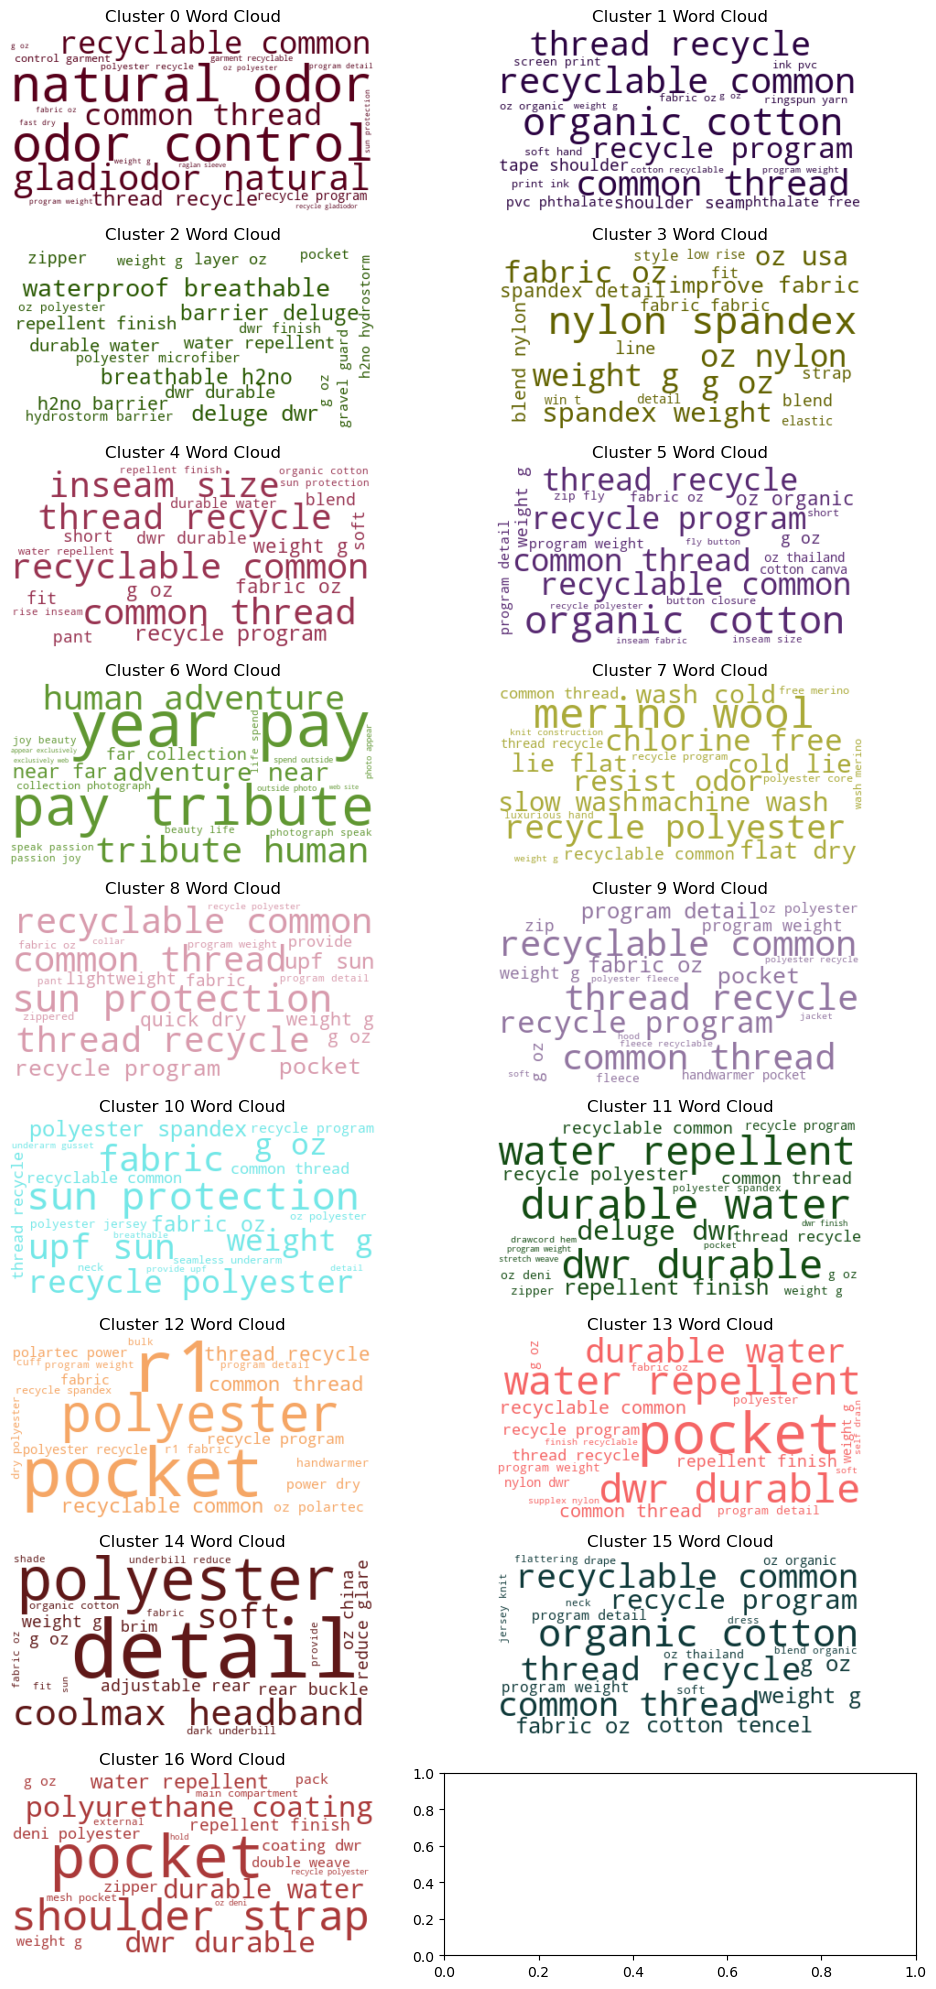

In [28]:
# Setting
n_cluster = 18
fig, axs = plt.subplots(9, 2, figsize=(10, 20))
axs = axs.flatten()
    
# Iterating over each cluster to generate and display a WordCloud.
for i in range(n_cluster):
    # Joining all lemmatized descriptions
    cluster_words = ' '.join(NF_corpus[NF_corpus['Cluster_KMeans'] == i]['description_lemmatized'])

    # Skip the cluster if it contains no words
    if len(cluster_words) == 0:
        print(f"Skipping cluster {i} as it contains no words.")
        continue

    # Creating a WordCloud with a uniform color for all words
    color_func = SimpleGroupedColorFunc(color=color_map[i])    
    wordcloud = WordCloud(background_color='white', contour_width=2, max_words=20, color_func=color_func).generate(cluster_words)
    
    # Displaying the WordCloud on the corresponding subplot
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis("off")
    axs[i].set_title(f"Cluster {i} Word Cloud")

plt.tight_layout()
plt.show()

</u><ins><center> <font color="#ffe800"><ins>Observations</font> </center>

**WCSS Progressive Decrease**: As expected, WCSS decreases as the number of clusters (K) increases. This is due to the fact that smaller clusters are generally more consistent internally, thus reducing the sum of squares of distances within the cluster.

**Increased Silhouette Scores**: Silhouette scores increase with the number of clusters up to K=18, indicating improved cluster separation and consistency. The silhouette score reaches its peak at K=18, then stagnates and begins to decrease slightly at K=20.

**Choice of K=17 based on Silhouette Score**: The choice of K=17 is justified by the highest silhouette score, suggesting a good balance between intra-cluster cohesion and inter-cluster separation at this number of clusters.

**Visualization with t-SNE**: t-SNE visualizations show clear cluster formation without apparent outliers, even when some points of different clusters overlap slightly. This may indicate that, although some products share similar characteristics across clusters, they retain unique distinctions that classify them into separate groups.

</u><ins><center> <font color="#ffe800"><ins>Conclusion</font> </center>

Considering both WCSS, silhouette scores and t-SNE visualizations, K=17 appears to be a robust choice for the number of clusters in this context. This high number of clusters captures fine granularity and detailed segmentation of North Face product descriptions, potentially reflecting significant diversity in product characteristics.

However, segmentation into 17 clusters also presents challenges, particularly in terms of readability and exploitability of clusters. Each cluster will need to be closely examined to identify specific themes and trends, and to assess whether the distinction between certain nearby clusters warrants their separation.

The decision to proceed with K=17 should therefore be supported by a qualitative analysis of the clusters formed, considering their commercial relevance and usefulness for the recommendation system. If clusters seem too fragmented or if some are not distinct enough to justify their separation, it might be wise to readjust the number of clusters or explore alternative methods to consolidate similar groups.

In conclusion, choosing K=17 offers detailed segmentation that, with deep analysis, can reveal valuable insights about North Face’s products, helping to refine product recommendations and improve the user experience on the website.

### 3.2 - DBSCAN


#### 3.2.1 - TF-IDF

In [29]:
# Initialize the TF-IDF vector
dbscan_vectorizer = TfidfVectorizer()

# Apply the TF-IDF vectorization
X_DBSCAN = dbscan_vectorizer.fit_transform(NF_corpus['description_lemmatized'])

#### 3.2.2 - DBSCAN

Text(0, 0.5, 'Distance')

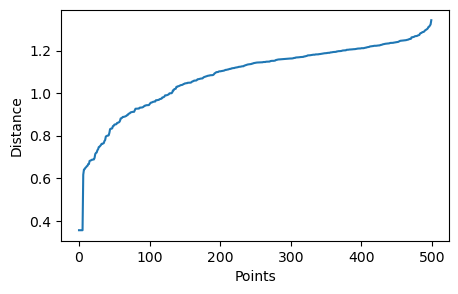

In [30]:
# Searching eps
nearest_neighbors = NearestNeighbors(n_neighbors=6)
neighbors = nearest_neighbors.fit(X_DBSCAN)
distances, indices = neighbors.kneighbors(X_DBSCAN)
distances = np.sort(distances[:,5], axis=0)

plt.figure(figsize=(5,3))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

In [31]:
# Calculate the cosine similarity matrix for the documents
cosine_sim_matrix = cosine_similarity(X_DBSCAN)

# Transform cosine similarities to distances suitable for DBSCAN
distance_matrix = np.clip(1 - cosine_sim_matrix, 0, 1)

# Applying DBSCAN clustering
dbscan = DBSCAN(eps=0.6, min_samples=6, metric="precomputed")
DB_clusters = dbscan.fit_predict(distance_matrix)

# Printing the unique cluster labels and their counts
print(np.unique(dbscan.labels_, return_counts=True))

# Adding the DBSCAN cluster labels to the NF_corpus DataFrame
NF_corpus['Cluster_DBSCAN'] = DB_clusters

# Displaying NF_corpus
NF_corpus.head()

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64), array([257,  12,  12,   9,  32,  55,  23,   8,  22,   6,   8,  15,   7,
        15,   6,   7,   6], dtype=int64))


id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      article  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                 article_description simple_article  \
0   There's a reason why our boxers are a cult fa...          Boxer   
1   Skinning up Glory requires enough movement wi...          Brief   
2   These superbreathable no-fly briefs are the m...          Brief   
3   Skin in, climb ice, switch to rock, traverse ...          Pants   
4   On high ridges, steep ice and anything alpine...         Jacket   

                              description_lemmatized  len_description  \
0  reason boxer cult favorite    cool   especiall...              728   
1  skin glory require movement boxer decide poach...              792   
2  superbreathable fly brief minimalist choice hi...              682   
3  skin   climb ice   switch rock   traverse knif...              989   
4  high ridge   steep ice alpine   jacket serve t...             1469   

   word_count  Cluster_KMeans  Cluster_DBSCAN  
0         109               0              -1  
1         125               8              -1  
2         100               8              -1  
3         143              11              -1  
4         209              11               0

#### 3.2.3 - Visualization of clusters identified by DBSCAN model

In [32]:
# Perform t-SNE dimensionality reduction on the TF-IDF matrix
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_DBSCAN)

# Creating a DataFrame
df_tsne = pd.DataFrame({
    'TSNE 1': X_embedded[:, 0],
    'TSNE 2': X_embedded[:, 1],
    'Cluster': DB_clusters
})

# Converting the 'Cluster' column to a categorical type
df_tsne['Cluster'] = df_tsne['Cluster'].astype('category')

# Using Plotly Express to create an interactive scatter plot of the t-SNE results
fig = px.scatter(df_tsne, x='TSNE 1', y='TSNE 2', color='Cluster',
                 color_discrete_map=color_map,
                 title='Visualisation des clusters avec t-SNE',
                )

fig.update_layout(xaxis_title='TSNE 1', yaxis_title='TSNE 2')
fig.show()

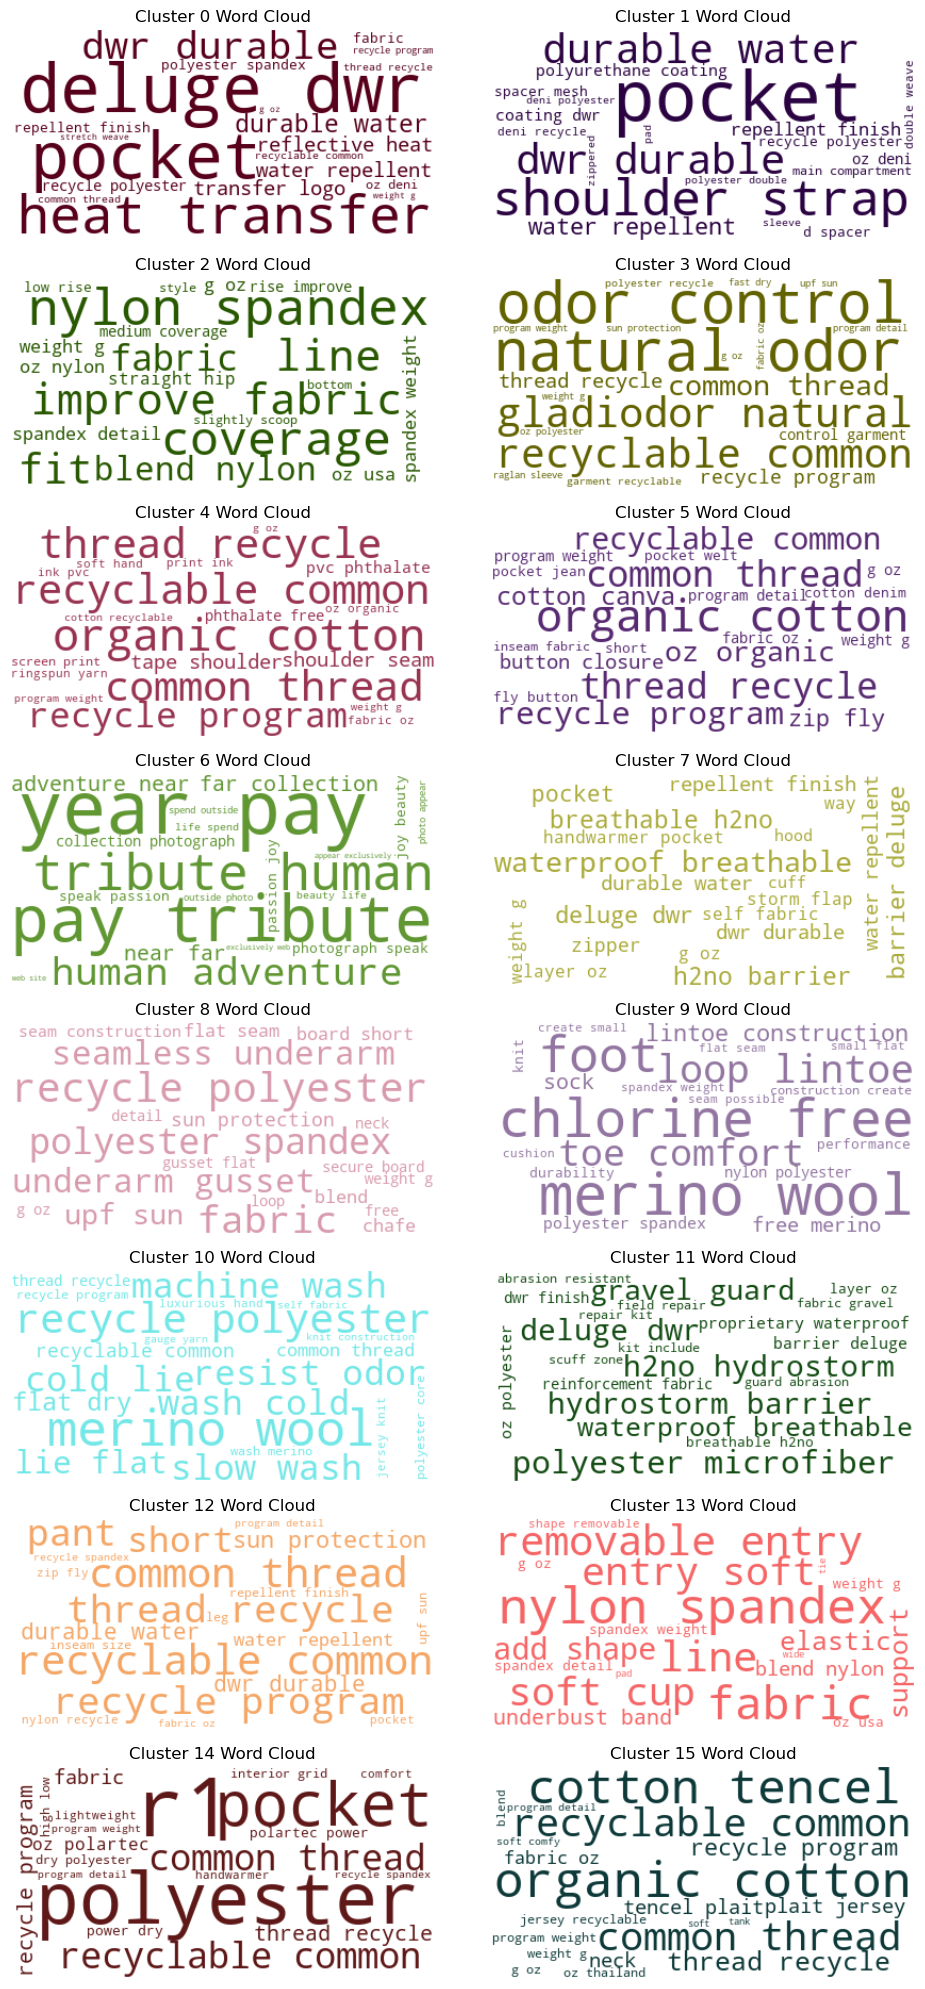

In [33]:
# Setting
n_cluster = 16
fig, axs = plt.subplots(8, 2, figsize=(10, 20))
axs = axs.flatten()

# Iterating over each cluster to generate and display a WordCloud.
for i in range(n_cluster):  
    # Joining all lemmatized descriptions
    cluster_words = ' '.join(NF_corpus[NF_corpus['Cluster_DBSCAN'] == i]['description_lemmatized'])
    # Creating a WordCloud with a uniform color for all words
    color_func = SimpleGroupedColorFunc(color=color_map[i])
    wordcloud = WordCloud(background_color='white', contour_width=2, max_words=20, color_func=color_func).generate(cluster_words)
    # Displaying the WordCloud on the corresponding subplot
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis("off")
    axs[i].set_title(f"Cluster {i} Word Cloud")
    
plt.tight_layout()
plt.show()

</u><ins><center> <font color="#ffe800"><ins>Observations</font> </center>

**Adaptability of DBSCAN**: DBSCAN has shown its ability to identify clusters of different sizes and shapes within your dataset. This demonstrates the flexibility of DBSCAN in dealing with varied textual data, where the density of points (here, product descriptions) can vary significantly.

**Outlier detection**: With 257 points classified as outliers, DBSCAN was able to isolate a significant number of descriptions that do not easily fit into well-defined groups. This can indicate either the presence of very unique products in your catalog, or descriptions that differ significantly from others in terms of vocabulary used.

**Cluster formation**: The 16 identified clusters (excluding outliers) show diversity in product distribution, ranging from small groups of 6 to larger clusters of 55 descriptions. This heterogeneous distribution can reflect the diversity of products and descriptors used in your catalog.

**Critical parameterization**: The choice of eps=0.6 and min_samples=6 was crucial to obtain a segmentation that seems consistent with the underlying structure of the data. Nevertheless, the presence of a large number of outliers suggests that adjusting these parameters could further improve the quality of clusters.

**Comparison with other methods**: Although DBSCAN succeeded in forming separate clusters, comparison with KMeans and HDBSCAN results, particularly in terms of cluster consistency and outlier management, is essential to choose the most suitable clustering method for your goals.

**Implications for recommendations**: Clusters formed by DBSCAN, despite the presence of outliers, could provide an interesting basis for developing personalized product recommendations. It would be useful to explore further how the products in each cluster are linked and whether these relationships reflect users' preferences or purchasing behaviors.

</u><ins><center> <font color="#ffe800"><ins>Conclusion</font> </center>

DBSCAN has demonstrated some ability to group complex product descriptions, although outlier management and parameter setting require special attention. Visualization via t-SNE helped visually validate the effectiveness of segmentation, providing a promising path for improving recommendation systems on The North Face’s website.

### 3.3 - HDBSCAN

#### 3.3.1 - TF-IDF

In [34]:
# Initialize the TF-IDF vector
hdbscan_vectorizer = TfidfVectorizer()

# Apply TF-IDF vectorization
X_HDBSCAN = hdbscan_vectorizer.fit_transform(NF_corpus['description_lemmatized'])

#### 3.3.2 - HDBSCAN

In [35]:
# Initialize the HDBSCAN instance
hdbscan = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

# Fit the model and predict cluster labels for the documents
hdb_clusters = hdbscan.fit_predict(X_HDBSCAN)

# Print the unique cluster labels generated by HDBSCAN
print(np.unique(hdbscan.labels_, return_counts=True))

# Add the HDBSCAN cluster labels to the NF_corpus DataFrame
NF_corpus['Cluster_HDBSCAN'] = hdb_clusters

# Display NF_corpus
NF_corpus.head()

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19], dtype=int64), array([211,   8,   8,  15,   9,  23,  61,  24,   7,   6,  31,   7,   6,
         8,   6,  16,   7,   9,   5,  24,   9], dtype=int64))


id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      article  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                 article_description simple_article  \
0   There's a reason why our boxers are a cult fa...          Boxer   
1   Skinning up Glory requires enough movement wi...          Brief   
2   These superbreathable no-fly briefs are the m...          Brief   
3   Skin in, climb ice, switch to rock, traverse ...          Pants   
4   On high ridges, steep ice and anything alpine...         Jacket   

                              description_lemmatized  len_description  \
0  reason boxer cult favorite    cool   especiall...              728   
1  skin glory require movement boxer decide poach...              792   
2  superbreathable fly brief minimalist choice hi...              682   
3  skin   climb ice   switch rock   traverse knif...              989   
4  high ridge   steep ice alpine   jacket serve t...             1469   

   word_count  Cluster_KMeans  Cluster_DBSCAN  Cluster_HDBSCAN  
0         109               0              -1               -1  
1         125               8              -1               -1  
2         100               8              -1               -1  
3         143              11              -1               18  
4         209              11               0               19

#### 3.3.3 - Insights from HDBSCAN clustering

In [36]:
# Perform t-SNE dimensionality reduction on the TF-IDF matrix
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_HDBSCAN)

# Creating a DataFrame
df_tsne = pd.DataFrame({
    'TSNE 1': X_embedded[:, 0],
    'TSNE 2': X_embedded[:, 1],
    'Cluster': hdb_clusters
})

# Converting the 'Cluster' column to a categorical type
df_tsne['Cluster'] = df_tsne['Cluster'].astype('category')

# Using Plotly Express to create an interactive scatter plot of the t-SNE results
fig = px.scatter(df_tsne, x='TSNE 1', y='TSNE 2', color='Cluster',
                 color_discrete_map=color_map,
                 title='Visualisation des clusters avec t-SNE',
                )

fig.update_layout(xaxis_title='TSNE 1', yaxis_title='TSNE 2')
fig.show()

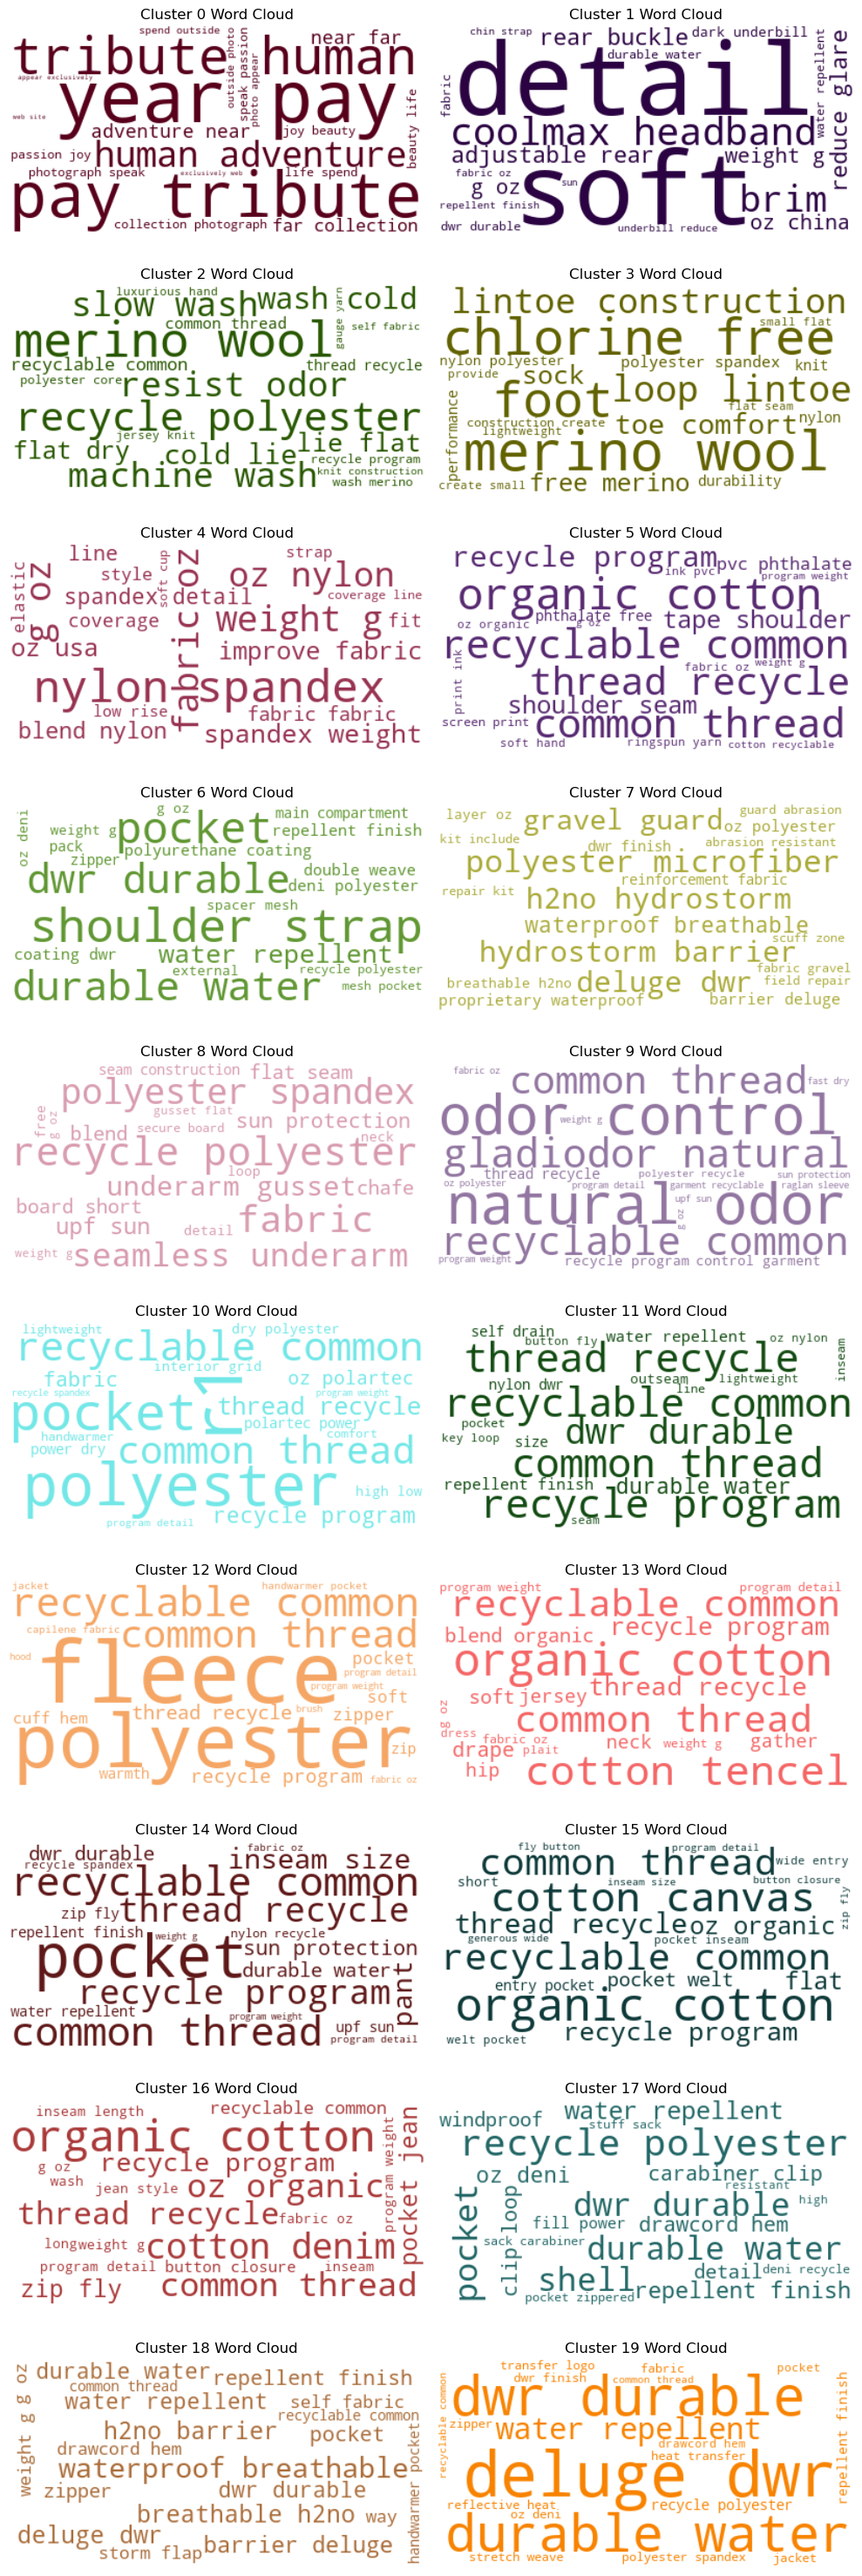

In [37]:
# Setting
n_cluster = 20
fig, axs = plt.subplots(10, 2, figsize=(10, 30))
axs = axs.flatten()

# Iterating over each cluster to generate and display a WordCloud.
for i in range(n_cluster):   
    # Joining all lemmatized descriptions
    cluster_words = ' '.join(NF_corpus[NF_corpus['Cluster_HDBSCAN'] == i]['description_lemmatized'])
    # Creating a WordCloud with a uniform color for all words
    color_func = SimpleGroupedColorFunc(color=color_map[i])
    wordcloud = WordCloud(background_color='white', contour_width=2, max_words=20, color_func=color_func).generate(cluster_words)
    # Displaying the WordCloud on the corresponding subplot
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis("off")
    axs[i].set_title(f"Cluster {i} Word Cloud")
    
plt.tight_layout()
plt.show()

</u><ins><center> <font color="#ffe800"><ins>Observations</font> </center>

**Flexibility and adaptability**: HDBSCAN has demonstrated its ability to adapt to the diversity of textual data, forming 20 distinct clusters in addition to isolating outliers. This method seems particularly effective at dealing with density variations within data, offering a more nuanced segmentation compared to approaches like KMeans and DBSCAN.

**Outlier reduction**: With 211 descriptions of products classified as outliers, HDBSCAN shows a significant improvement in outlier data management compared to DBSCAN. This feature is advantageous to refine groups of similar products without being too disturbed by extreme cases.

**Cluster diversity**: The formation of clusters of different sizes and shapes, as observed in HDBSCAN results and confirmed by t-SNE visualization, reflects the diversity of product descriptions. This suggests that HDBSCAN has managed to capture significant nuances in the data, which could enrich the product recommendations.

**Comparison with KMeans and DBSCAN**: The performance of HDBSCAN, in terms of number of clusters formed and management of outliers, is comparable to that of KMeans with the advantage of a more flexible approach and less sensitive to initial parameters. This method seems to offer a good compromise between KMeans rigidity and DBSCAN sensitivity to parameters.

**Implications for recommendation systems**: Clusters formed by HDBSCAN provide a solid foundation for developing custom recommendations. Identifying distinct and consistent product groups can make it easier for users to suggest similar items, improving the browsing experience on The North Face’s site.

**Future optimization**: Although HDBSCAN has shown good initial results, further exploration of parameters and data preprocessing methods could further improve cluster relevance. The evaluation of recommendations based on these clusters would also be a key step to validate the utility of the model in a real context.

</u><ins><center> <font color="#ffe800"><ins>Conclusion</font> </center>

HDBSCAN presents itself as a promising clustering method for your project, offering a balance between the ability to detect similar product groups and effective outlier management. Its application as part of the recommendation systems on the North Face website could significantly improve the user experience by providing more relevant and personalized product suggestions.

</u><ins><center> <font color="#00df00"><ins>**Topic Modeling Conclusions**</font> </center>

<font color="#00df00"><ins>General Conclusion on Clustering Methods</font>

1. KMeans offered a robust and simple approach to segment product descriptions into a predefined number of clusters. This made it possible to create homogeneous groups, facilitating the recommendation of similar products. However, the need to define the number of clusters in advance and the sensitivity to the starting points may limit the flexibility of this method.

2. DBSCAN has shown an ability to detect density-based clusters without requiring the specification of the number of clusters. Nevertheless, the sensitivity of DBSCAN to eps and min_sample parameters, as well as the notable presence of outliers, make its application less predictable and potentially less useful for certain product categories.

3. HDBSCAN combines the advantages of DBSCAN with increased flexibility, forming clusters of different densities while minimizing the number of outliers. This method produced a detailed and nuanced segmentation of products, which could lead to more precise and personalized recommendations.

<font color="#00df00"><ins>Choice between KMeans, DBSCAN and HDBSCAN for Recommendation System</font>

**Adaptability and Precision**: HDBSCAN offers superior adaptability and is able to handle a wider variety of data structures, which is especially advantageous for varied product descriptions. If the accuracy and customization of recommendations is a priority, HDBSCAN seems to be the best choice.

**Simplicity and Stability**: KMeans is easier to understand and implement, with more predictable and stable results across different datasets. If simplicity and ease of implementation are essential, KMeans might be preferred.

**Flexibility and Outlier Management**: DBSCAN stands out for its ability to detect density-based clusters without requiring the specification of a number of clusters in advance. This method is particularly useful for identifying natural groups in the data and effectively managing outliers. However, the sensitivity of DBSCAN to eps and min_samples parameters can make its application tricky in some cases.

**Evaluation of Recommendations**: The effectiveness of a clustering method for a recommendation system is measured not only by the quality of the clusters, but also by the relevance of the recommendations generated. Testing recommendations from KMeans, DBSCAN and HDBSCAN with users could provide valuable insights to assess their real effectiveness and make an informed choice.

In summary, **HDBSCAN** proves to be the most suitable for personalized recommendations thanks to its ability to detect clusters of various shapes and densities. KMeans offers a more direct and stable approach, adapted if simplicity is a priority. DBSCAN, on the other hand, can be advantageous in scenarios where outlier management and detection of natural clusters are crucial, despite its dependence on specific parameters. A practical assessment of the recommendations provided by each method will help determine the most effective approach for your system.

## 4- Recommandation system

In [38]:
# Define function to find similar items
def find_similar_items(product_id, data, cluster_column = 'Cluster_HDBSCAN'):
    # Ensure the product_id is an integer
    product_id = int(product_id)
    
    # Retrieve the cluster label of the specified product using its ID
    cluster = data.loc[data['id'] == product_id, cluster_column].iloc[0]
    
    # Identify all products within the same cluster as the specified product
    similar_items_ids = data[data[cluster_column] == cluster]['id'].tolist()
  
    # Remove the specified product's ID from the list of similar items
    similar_items_ids.remove(product_id)

    # Limit the number of similar items returned to the top 10.
    return similar_items_ids[:10]

In [39]:
# Example
product_id = '1'  
print(find_similar_items(product_id, NF_corpus))

[2, 3, 6, 9, 11, 12, 14, 17, 27, 28]


## 5- Theme modeling

In [40]:
# Initialize the LSA model
lsa_model = TruncatedSVD(n_components=10)

# Fit the LSA model to the TF-IDF matrix (X_HDBSCAN) and transform the data
topic_encoded_df = lsa_model.fit_transform(X_HDBSCAN)

# Convert the array of topic strengths for each document into a DataFrame
topic_encoded_df = pd.DataFrame(topic_encoded_df, columns=["Topic_" + str(i) for i in range(10)])

# Concatenate the original NF_corpus DataFrame with the new DataFrame of topic strengths
data = pd.concat([NF_corpus, topic_encoded_df], axis=1)

In [41]:
# Display data
data.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      article  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                 article_description simple_article  \
0   There's a reason why our boxers are a cult fa...          Boxer   
1   Skinning up Glory requires enough movement wi...          Brief   
2   These superbreathable no-fly briefs are the m...          Brief   
3   Skin in, climb ice, switch to rock, traverse ...          Pants   
4   On high ridges, steep ice and anything alpine...         Jacket   

                              description_lemmatized  len_description  \
0  reason boxer cult favorite    cool   especiall...              728   
1  skin glory require movement boxer decide poach...              792   
2  superbreathable fly brief minimalist choice hi...              682   
3  skin   climb ice   switch rock   traverse knif...              989   
4  high ridge   steep ice alpine   jacket serve t...             1469   

   word_count  Cluster_KMeans  Cluster_DBSCAN  ...   Topic_0   Topic_1  \
0         109               0              -1  ...  0.289110 -0.076155   
1         125               8              -1  ...  0.296827 -0.088450   
2         100               8              -1  ...  0.267737 -0.103713   
3         143              11              -1  ...  0.367318 -0.265245   
4         209              11               0  ...  0.378943 -0.280310   

    Topic_2   Topic_3   Topic_4   Topic_5   Topic_6   Topic_7   Topic_8  \
0  0.198581  0.077197 -0.131064 -0.012914 -0.056958 -0.025143 -0.155200   
1  0.106880  0.089154 -0.002883  0.091204 -0.092455 -0.037465 -0.113530   
2  0.112966  0.020904 -0.004985  0.106142 -0.010214  0.052453 -0.052448   
3 -0.111126 -0.165400  0.039279 -0.023791 -0.002936 -0.047821 -0.040693   
4 -0.027603 -0.234228 -0.040488 -0.013707  0.046099  0.038933  0.035122   

    Topic_9  
0  0.016558  
1 -0.065293  
2 -0.004145  
3 -0.129461  
4 -0.171862  

[5 rows x 21 columns]

## 6- Recommandation

In [42]:
def get_recommendations(keyword, tfidf_vectorizer, lsa_model, data, topic_encoded_df, top_n=5):
 
    # Turn keyword into vector TF-IDF
    keyword_vector = hdbscan_vectorizer.transform([keyword])
    
    # Using LSA to transform the keyword vector
    keyword_topic_vector = lsa_model.transform(keyword_vector)
    
    # Calculate the cosine similarity between the keyword vector and document vectors
    similarities = cosine_similarity(keyword_topic_vector, topic_encoded_df).flatten()
    
    # Find clues from the most similar documents
    most_similar_docs_indices = similarities.argsort()[-top_n:][::-1]
    
    # Return descriptions of the most similar documents
    return data.loc[most_similar_docs_indices, 'description']


In [43]:
# Prompt the user to input a keyword for which they want to find similar documents
keyword = input()
print(f'What do you want?', keyword)

# Get recommendations based on the input keyword using the previously defined function.
recommendations = get_recommendations(keyword, hdbscan_vectorizer, lsa_model, NF_corpus, topic_encoded_df, top_n=5)

# Print the recommendations.
print('\nRecommendations:')
print(recommendations)

What do you want? swim

Recommendations:
252    Solid kupala top - Our fixed triangle bikini t...
243    Print kupala top - Our fixed triangle bikini t...
220    Solid bibiana 1 piece - The sporty Bibiana One...
218    Solid adour btm - Adours feature a scooped, lo...
241    Print bibiana top - The athletic Bibiana Top's...
Name: description, dtype: object
